In [91]:
from distributed import Nanny
from matplotlib.pyplot import contour
from networkx.algorithms.bipartite.basic import color

# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

Rpb1_datasets = [
    "test_data/2024-10-11/Halo552_Rpb1_embryo03"
]

Dl_datasets = [
    "test_data/2024-11-08/Dl-Halo552_MCP-GFP_twiPE_embryo01",
    "test_data/2024-11-20/Dl-Halo552_MCP-GFP_twiPE_embryo01",
    "test_data/2024-06-11/Dl-Halo552-DeltadsRed_embryo01"
]

Dl_datasets_2D = [
    "test_data/"
]

NSPARC_datasets = ['test_data/NSPARC/2025-02-27/Dl-Halo552_MCP-GFP_noRep_3z_5min',
                   'test_data/NSPARC/2025-03-11/Dl-Halo552(10%)_MCP-GFP_snaBAC_GregorSettings3D(~)_embryo02',
                   'test_data/NSPARC/2025-03-11/Dl-Halo552(10%)_MCP-GFP_snaBAC_GregorSettings(~)_embryo01_nc12',
                   'test_data/NSPARC/2025-03-11/Dl-Halo552(10%)_MCP-GFP_snaBAC_GregorSettings(~)_embryo01_nc13',
                   'test_data/NSPARC/2025-03-11/Dl-Halo552(10%)_MCP-GFP_snaBAC_GregorSettings(~)_embryo01_nc14',
]

Andrea_test_datasets = ['test_data/NSPARC/3-05-bcdgfp-mcphalo552-test-embryo2007']
test_dataset_name = dataset_folder + NSPARC_datasets[3]
# test_dataset_name = dataset_folder + Andrea_test_datasets[0]
# test_dataset_name = dataset_folder + Dl_datasets[2]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-11/Dl-Halo552(10%)_MCP-GFP_snaBAC_GregorSettings(~)_embryo01_nc13


In [6]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

root = tk.Tk()
root.withdraw();

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [34]:
mpl.use('TkAgg')
# %matplotlib widget

In [7]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [8]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

if not ms2_import_previous:
    dataset.save()

In [38]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        # scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="10GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44493 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:35909' processes=14 threads=14, memory=130.39 GiB>


In [39]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44493/status,
Dashboard: http://127.0.0.1:44493/status,Workers: 14
Total threads: 14,Total memory: 130.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35909,Workers: 14
Dashboard: http://127.0.0.1:44493/status,Total threads: 14
Started: Just now,Total memory: 130.39 GiB
Comm: tcp://127.0.0.1:35983,Total threads: 1
Dashboard: http://127.0.0.1:45179/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:35121,


In [9]:
client.shutdown()

In [7]:
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [9]:
# Set the channels for spot and nuclear tracking
# spot_channel = 0
nuclear_channel = 1

## Nuclear Tracking

In [10]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [11]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')

    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')

    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[nuclear_channel],
        global_metadata=dataset.export_global_metadata[nuclear_channel],
        frame_metadata=dataset.export_frame_metadata[nuclear_channel],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )

    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


## Run for 2D Data

In [43]:
### Run for 2D data
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[nuclear_channel],
        global_metadata=dataset.export_global_metadata[nuclear_channel],
        frame_metadata=dataset.export_frame_metadata[nuclear_channel],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        spatial_axes='yx',
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
##### Run for 2D data

def modify_params(params):
    for key, value in params.items():
        if isinstance(value, dict):  # Recursively process dictionaries
            modify_params(value)
        elif isinstance(value, np.ndarray):
            if value.ndim == 1 and value.shape[0] == 3:  # Remove first component for 3-vectors
                params[key] = value[1:]
            elif value.ndim == 3 and value.shape[0] == 3:  # Remove top and bottom slices for footprints
                params[key] = value[1]
        elif isinstance(value, tuple) and len(value) == 2 and isinstance(value[1], np.ndarray):
            if value[1].ndim == 3 and value[1].shape[0] > 2:  # Footprint in a tuple structure
                params[key] = (value[0], value[1][1])

modify_params(nuclear_tracking.default_params)


Do nuclear tracking for the dataset


In [44]:
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

2025-04-02 11:59:28,169 - distributed.worker - WARNING - Compute Failed
Key:       denoise_movie-7897dcdbe6ec5f5387682aa32cab8165
Function:  denoise_movie
args:      (array([[[[0, 1, 0, ..., 0, 0, 3],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 1, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0]]]], dtype=uint16))
kwargs:    {}
Exception: "RuntimeError('sequence argument must have length equal to input rank')"

2025-04-02 11:59:28,179 - distributed.worker - WARNING - C

RuntimeError: sequence argument must have length equal to input rank

In [17]:
nuclear_tracking.mitosis_dataframe

,label,y,x,nuclear_intensity_mean,nuclear_intensity_stdev,frame,original_frame,t_s,t_frame,nuclear_cycle,y_pixel,x_pixel,particle,v_y,v_x,parent
0,2,9.023713,6.683992,0.304163,0.533177,1027,1027,1078.478727,1028,13,219.537914,162.614837,1,0.273138,0.189467,<NA>
1,4,11.131362,33.569504,0.296766,0.531479,1027,1027,1078.478727,1028,13,270.814888,816.712426,2,0.951983,0.374535,<NA>
2,5,13.594703,26.295243,0.314640,0.555888,1027,1027,1078.478727,1028,13,330.745501,639.736932,3,NaN,NaN,<NA>
3,8,16.028910,6.377822,0.296627,0.527352,1027,1027,1078.478727,1028,13,389.967320,155.166013,4,-0.553139,1.152304,<NA>
4,9,15.833967,13.928115,0.292172,0.540482,1027,1027,1078.478727,1028,13,385.224552,338.857085,5,0.081577,0.070800,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25369,26,35.153815,31.109334,0.579272,0.738869,1,1,2.265354,2,13,855.257114,756.858956,872,0.019626,-0.050874,<NA>
25370,27,35.186838,40.951865,0.476341,0.607039,1,1,2.265354,2,13,856.060549,996.317881,1043,0.047794,-0.063902,<NA>
25371,28,38.037458,8.012402,0.534272,0.696400,1,1,2.265354,2,13,925.413256,194.933718,269,-0.045228,-0.093027,<NA>
25372,29,37.953510,23.524280,0.682116,0.818927,1,1,2.265354,2,13,923.370899,572.322169,874,-0.063390,0.000569,<NA>


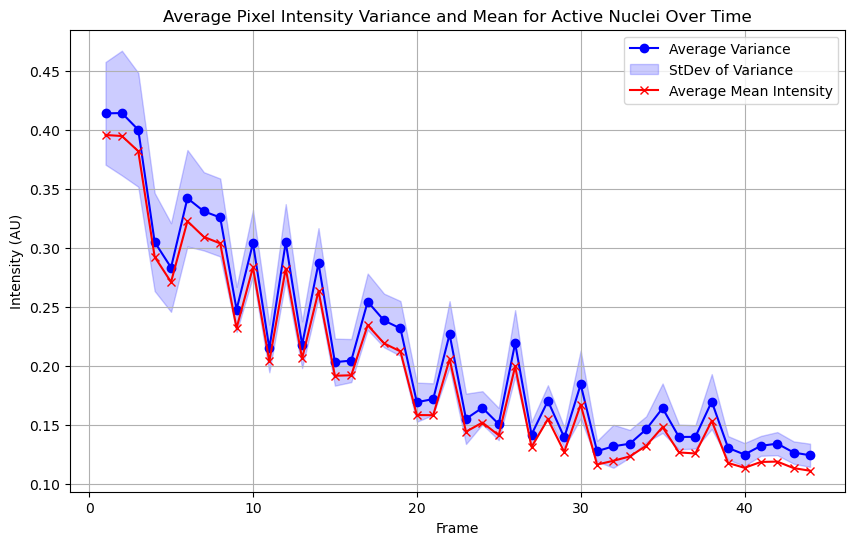

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_timewise_nucleus_intensity_variance_with_sem(df, data, mask, start_time, end_time):
    """
    Plots the mean pixel intensity variance and mean intensity over time,
    with the standard error of the mean (SEM) for the variance shown as a shaded region.

    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    mask (np.ndarray): 3D mask with labeled nuclei.
    start_time (int): Start time frame.
    end_time (int): End time frame.
    """
    timepoints = np.arange(start_time, end_time + 1)
    mean_variances = []
    sem_variances = []  # Standard error of the mean for variances
    mean_intensities = []
    
    for t in timepoints:
        # Filter for nuclei active at the current time point
        nuclei_at_t = df[df['frame'] == t]
        
        if nuclei_at_t.empty:
            mean_variances.append(np.nan)
            sem_variances.append(np.nan)
            mean_intensities.append(np.nan)
            continue
        
        # Calculate variance and mean intensity for all active nuclei at this time
        variances_at_t = (nuclei_at_t['nuclear_intensity_stdev']**2).to_numpy()
        intensities_at_t = nuclei_at_t['nuclear_intensity_mean'].to_numpy()
        
        # Average over all active nuclei
        mean_variances.append(np.mean(variances_at_t))
        mean_intensities.append(np.mean(intensities_at_t))
        
        # Calculate SEM for the variance
        sem_variances.append(np.std(variances_at_t))# / np.sqrt(len(variances_at_t)))
    
    # Plot mean variance with SEM as shaded region
    plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_variances, label='Average Variance', color='blue', marker='o')
    plt.fill_between(timepoints,
                     np.array(mean_variances) - np.array(sem_variances),
                     np.array(mean_variances) + np.array(sem_variances),
                     color='blue', alpha=0.2, label='StDev of Variance')
    
    # Plot mean intensity over time with Stdev as shaded region
    # plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_intensities, label='Average Mean Intensity', color='red', marker='x')
    # plt.fill_between(timepoints,
    #                     np.array(mean_intensities) - np.sqrt(mean_variances),
    #                     np.array(mean_intensities) + np.sqrt(mean_variances),
    #                     color='red', alpha=0.2, label='StDev of Intensity')
    
    # Plot details
    plt.title(f'Average Pixel Intensity Variance and Mean for Active Nuclei Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Intensity (AU)')
    # plt.ylim(0, 27)
    plt.legend()
    plt.grid(True)
    plt.show()


    
start_frame=0
end_frame=1000
plot_timewise_nucleus_intensity_variance_with_sem(nuclear_tracking.mitosis_dataframe, 
                                dataset.channels_full_dataset[0], 
                                nuclear_tracking.reordered_labels, 
                                start_frame,
                                end_frame)


In [13]:
nuclear_tracking.reordered_labels

<zarr.core.Array (44, 3, 1024, 1024) uint32>

In [84]:
from skimage.measure import label
import numpy as np
import scipy.ndimage as ndimage
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import logging
from typing import Tuple, List, Optional, Union, Dict, Any
import warnings
from matplotlib.colors import ListedColormap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def top_hat_filter_2d(image: np.ndarray, structure_size: int = 3) -> np.ndarray:
    """
    Applies a 2D top-hat filter to enhance bright regions smaller than the structuring element.

    Parameters:
        image (ndarray): Input grayscale image.
        structure_size (int): Size of the square structuring element.

    Returns:
        ndarray: The top-hat filtered image.
    """
    if image is None or np.all(np.isnan(image)):
        logger.warning("Empty or NaN image provided to top-hat filter")
        return np.zeros_like(image) if image is not None else None

    structure = np.ones((structure_size, structure_size))  # Structuring element
    opened_image = ndimage.grey_opening(image, structure=structure)  # Morphological opening
    top_hat = image - opened_image  # Compute top-hat transform
    return top_hat

def process_nuclear_slice(
    frame_nuclear_labels: np.ndarray,
    frame_nuclear_data: np.ndarray,
    nucleus_id: int,
    sigma_xy: float = 0,
    z_plane: Optional[int] = None,
    filter_type: str = 'gaussian'
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray],
           Optional[int], Optional[int], Optional[int], Optional[int], Optional[int]]:
    """
    Extracts and processes a slice of nuclear data for a given nucleus ID.

    Supports both 2D and 3D datasets.

    Parameters:
        frame_nuclear_labels (ndarray): Labeled nuclear mask (2D or 3D).
        frame_nuclear_data (ndarray): Intensity data (same shape as labels).
        nucleus_id (int): ID of the nucleus to process.
        sigma_xy (float): Parameter for spatial filtering:
                         - For Gaussian filter: standard deviation for blur
                         - For Top-hat filter: size of the structuring element
        z_plane (int, optional): Z-plane index for 3D data. If None, selects the plane with maximum nucleus presence.
        filter_type (str): Type of filter to apply ('gaussian' or 'tophat').

    Returns:
        tuple: (cropped_nucleus_slice, filtered_nucleus_slice, z_plane_data, z_plane, min_y, max_y, min_x, max_x)
               Returns None values if processing fails.
    """
    try:
        # Input validation
        if frame_nuclear_labels is None or frame_nuclear_data is None:
            logger.error("Null input data provided")
            return None, None, None, None, None, None, None, None

        if frame_nuclear_labels.shape != frame_nuclear_data.shape:
            logger.error(f"Shape mismatch: labels {frame_nuclear_labels.shape}, data {frame_nuclear_data.shape}")
            return None, None, None, None, None, None, None, None

        if nucleus_id not in np.unique(frame_nuclear_labels):
            logger.warning(f"Nucleus ID {nucleus_id} not found in labels")
            return None, None, None, None, None, None, None, None

        # Create nucleus mask and apply to data
        nucleus_mask = (frame_nuclear_labels == nucleus_id)
        nucleus_mask_data = frame_nuclear_data * nucleus_mask  # Apply mask

        # Handle dimensionality
        if frame_nuclear_data.ndim == 3:  # 3D Case
            if z_plane is None:
                plane_sums = np.sum(nucleus_mask_data, axis=(1, 2))
                if np.all(plane_sums == 0):
                    logger.warning(f"No signal found for nucleus {nucleus_id} in any z-plane")
                    return None, None, None, None, None, None, None, None
                z_plane = np.argmax(plane_sums)  # Choose slice with most signal

            if z_plane >= frame_nuclear_data.shape[0]:
                logger.error(f"Z-plane index {z_plane} out of bounds (max: {frame_nuclear_data.shape[0] - 1})")
                return None, None, None, None, None, None, None, None

            z_plane_data = nucleus_mask_data[z_plane, :, :]  # Extract the selected Z-plane

        elif frame_nuclear_data.ndim == 2:  # 2D Case
            z_plane = None
            z_plane_data = nucleus_mask_data
        else:
            raise ValueError(f"Input data must be either 2D or 3D, got {frame_nuclear_data.ndim}D")

        # Check if nucleus pixels exist in the selected plane
        if not np.any(z_plane_data):
            logger.warning(f"No nucleus pixels found for ID {nucleus_id} in selected plane")
            return None, None, None, None, None, None, None, None

        # Get bounding box coordinates
        nucleus_coords = np.where(z_plane_data)
        if len(nucleus_coords[0]) == 0:  # No pixels found
            logger.warning(f"No coordinates found for nucleus {nucleus_id}")
            return None, None, None, None, None, None, None, None

        min_y, min_x = np.min(nucleus_coords[0]), np.min(nucleus_coords[1])
        max_y, max_x = np.max(nucleus_coords[0]), np.max(nucleus_coords[1])

        # Crop the nucleus region
        cropped_nucleus_slice = z_plane_data[min_y:max_y + 1, min_x:max_x + 1]

        # Apply filter to smooth the slice
        if filter_type.lower() == 'gaussian':
            filtered_nucleus_slice = ndimage.gaussian_filter(
                np.nan_to_num(cropped_nucleus_slice),
                sigma=max(0, sigma_xy),  # Ensure non-negative sigma
                mode='constant'
            )
        elif filter_type.lower() == 'tophat':
            # Use sigma_xy parameter as structure size for top-hat filter
            structure_size = max(3, int(sigma_xy))  # Minimum size of 3
            filtered_nucleus_slice = top_hat_filter_2d(cropped_nucleus_slice, structure_size)
        else:
            logger.warning(f"Unknown filter type '{filter_type}', defaulting to gaussian")
            filtered_nucleus_slice = ndimage.gaussian_filter(
                np.nan_to_num(cropped_nucleus_slice),
                sigma=max(0, sigma_xy),
                mode='constant'
            )

        return cropped_nucleus_slice, filtered_nucleus_slice, z_plane_data, z_plane, min_y, max_y, min_x, max_x

    except Exception as e:
        logger.error(f"Error processing nuclear slice: {str(e)}")
        return None, None, None, None, None, None, None, None

def segment_clusters(
    dataset,
    nuclear_tracking,
    nuclear_channel: int,
    frame: int,
    nucleus_id: int,
    method: str = 'contour',
    sigma_xy: float = 1,
    z_plane: Optional[int] = None,
    contour_cutoff: int = 8,
    window_size: int = 25,
    iterations: int = 20,
    plot: bool = False,
    filter_type: str = 'gaussian',
    plot_intermediate: bool = False
) -> Tuple[pd.DataFrame, Optional[List[np.ndarray]]]:
    """
    Segments clusters within a nucleus.

    Parameters:
        dataset: Dataset object containing image data.
        nuclear_tracking: Object containing tracked nuclear labels.
        nuclear_channel (int): Index of the nuclear channel.
        frame (int): Frame index to process.
        nucleus_id (int): ID of the nucleus to process.
        method (str): Segmentation method ('contour' or 'otsu').
        sigma_xy (float): Parameter for spatial filtering.
        z_plane (int, optional): Z-plane index for 3D data.
        contour_cutoff (int): Index to determine threshold level for contour method.
        window_size (int): Size of window for local thresholding in otsu method.
        iterations (int): Number of iterations for otsu method.
        plot (bool): Whether to display result plots.
        filter_type (str): Type of filter to apply ('gaussian' or 'tophat').
        plot_intermediate (bool): Whether to show intermediate processing steps for otsu method.

    Returns:
        tuple: (DataFrame with cluster coordinates, list of processed slices)
    """
    try:
        # Input validation
        if frame < 0 or frame >= len(nuclear_tracking.reordered_labels):
            logger.error(f"Invalid frame index: {frame}")
            return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"]), None

        if nuclear_channel < 0 or nuclear_channel >= len(dataset.channels_full_dataset):
            logger.error(f"Invalid nuclear channel index: {nuclear_channel}")
            return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"]), None

        # Get frame data
        frame_nuclear_labels = nuclear_tracking.reordered_labels[frame]
        frame_nuclear_data = dataset.channels_full_dataset[nuclear_channel][frame]

        # Process nuclear slice
        result = process_nuclear_slice(
            frame_nuclear_labels, frame_nuclear_data, nucleus_id, sigma_xy, z_plane, filter_type
        )

        if result[0] is None:  # Check if processing failed
            logger.warning(f"Failed to process nucleus {nucleus_id} in frame {frame}")
            return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"]), None

        cropped_nucleus_slice, filtered_nucleus_slice, z_plane_data, z_plane, min_y, max_y, min_x, max_x = result

        # Empty dataframe to return on failure
        empty_df = pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"])
        processed_slices = None

        # Apply segmentation method
        if method.lower() == 'contour':
            try:
                # Get full frame data for z-plane
                if z_plane is not None and frame_nuclear_data.ndim == 3:
                    full_frame_slice = frame_nuclear_data[z_plane]
                else:
                    full_frame_slice = frame_nuclear_data

                # Apply Gaussian filter
                full_frame_slice = ndimage.gaussian_filter(
                    np.nan_to_num(full_frame_slice),
                    sigma=sigma_xy,
                    mode='constant'
                )

                # Generate contour levels and threshold
                min_val = np.nanmin(full_frame_slice)
                max_val = np.nanmax(full_frame_slice)

                if min_val == max_val:
                    logger.warning("Frame has uniform intensity, cannot generate contours")
                    return empty_df, None

                contour_levels = np.linspace(min_val, max_val, 10)

                if contour_cutoff >= len(contour_levels):
                    logger.warning(f"Contour cutoff {contour_cutoff} exceeds available levels (max: {len(contour_levels)-1})")
                    contour_cutoff = len(contour_levels) - 1

                threshold = contour_levels[contour_cutoff]
                cluster_mask = filtered_nucleus_slice > threshold

            except Exception as e:
                logger.error(f"Error in contour method: {str(e)}")
                return empty_df, None

        elif method.lower() == 'otsu':
            try:
                # Check if filtered slice is suitable for Otsu thresholding
                if np.all(np.isnan(filtered_nucleus_slice)) or np.nanmax(filtered_nucleus_slice) == np.nanmin(filtered_nucleus_slice):
                    logger.warning("Cannot apply Otsu method on uniform or NaN slice")
                    return empty_df, None

                # Apply Otsu threshold
                otsu_threshold = threshold_otsu(filtered_nucleus_slice)
                thresholded_slice = np.where(filtered_nucleus_slice > otsu_threshold, cropped_nucleus_slice, 0)

                # Normalize the thresholded slice
                slice_min = np.nanmin(thresholded_slice)
                slice_max = np.nanmax(thresholded_slice)
                if slice_max == slice_min:
                    logger.warning("Thresholded slice has uniform intensity")
                    return empty_df, None

                rescaled_slice = (thresholded_slice - slice_min) / (slice_max - slice_min)
                current_slice = rescaled_slice

                # Save processed slices for visualization
                processed_slices = [current_slice]

                # Iterative local thresholding
                for i in range(iterations):
                    try:
                        # Calculate local statistics
                        local_sum = ndimage.uniform_filter(np.nan_to_num(current_slice), size=window_size, mode='constant')
                        local_count = ndimage.uniform_filter((~np.isnan(current_slice)).astype(float), size=window_size, mode='constant')

                        # Avoid division by zero
                        local_count = np.maximum(local_count, 1e-10)
                        local_mean = local_sum / local_count

                        local_squared_sum = ndimage.uniform_filter(np.nan_to_num(current_slice)**2, size=window_size, mode='constant')
                        local_variance = (local_squared_sum / local_count) - (local_mean**2)

                        # Ensure non-negative variance
                        local_variance = np.maximum(local_variance, 0)
                        local_std = np.sqrt(local_variance)

                        # Apply local threshold
                        local_threshold = local_mean + local_std
                        current_slice = np.clip(current_slice - local_threshold, 0, None)

                        # Normalize again if non-uniform
                        if np.nanmax(current_slice) > np.nanmin(current_slice):
                            current_slice = (current_slice - np.nanmin(current_slice)) / (np.nanmax(current_slice) - np.nanmin(current_slice))
                        else:
                            logger.warning(f"Uniform slice at iteration {i}")
                            break

                        processed_slices.append(current_slice)

                    except Exception as e:
                        logger.error(f"Error at iteration {i}: {str(e)}")
                        break

                cluster_mask = current_slice > 0.1

            except Exception as e:
                logger.error(f"Error in otsu method: {str(e)}")
                return empty_df, None
        else:
            logger.error(f"Unknown segmentation method: {method}")
            return empty_df, None

        # Label connected components in cluster mask
        labeled_clusters, num_clusters = label(cluster_mask, connectivity=2, return_num=True)

        # Create dataframe of cluster coordinates
        cluster_coords = []
        for i in range(1, num_clusters + 1):
            cluster_pixels = np.where(labeled_clusters == i)
            if len(cluster_pixels[0]) > 0:  # Ensure cluster has pixels
                y_crop, x_crop = np.nanmean(cluster_pixels[0]), np.nanmean(cluster_pixels[1])
                cluster_coords.append([y_crop, x_crop])

        cluster_df = pd.DataFrame(cluster_coords, columns=["y_crop", "x_crop"]) if cluster_coords else empty_df

        # Add original coordinates
        if not cluster_df.empty:
            cluster_df["y_original"] = cluster_df["y_crop"] + min_y
            cluster_df["x_original"] = cluster_df["x_crop"] + min_x
            cluster_df["cluster_id"] = range(1, len(cluster_df) + 1)

        # Create plots if requested
        if plot:
            plot_segmentation_results(
                cropped_nucleus_slice,
                filtered_nucleus_slice,
                cluster_mask,
                labeled_clusters,
                method=method,
                processed_slices=processed_slices if plot_intermediate else None
            )

        return cluster_df, processed_slices

    except Exception as e:
        logger.error(f"Error in segment_clusters: {str(e)}")
        return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"]), None

def segment_clusters_all_nuclei(
    dataset,
    nuclear_tracking,
    nuclear_channel: int,
    sigma_xy: float = 0,
    plot: bool = False,
    method: str = 'contour',
    filter_type: str = 'gaussian',
    frames: Optional[List[int]] = None,
    progress_callback: Optional[callable] = None
) -> pd.DataFrame:
    """
    Segments clusters for all nuclei across all frames or specified frames.

    Parameters:
        dataset: Dataset object containing image data.
        nuclear_tracking: Object containing tracked nuclear labels.
        nuclear_channel (int): Index of the nuclear channel.
        sigma_xy (float): Parameter for spatial filtering.
        plot (bool): Whether to display result plots.
        method (str): Segmentation method ('contour' or 'otsu').
        filter_type (str): Type of filter to apply ('gaussian' or 'tophat').
        frames (list, optional): List of specific frames to process. If None, processes all frames.
        progress_callback (callable, optional): Function to call with progress updates (0-100).

    Returns:
        DataFrame: Contains all cluster coordinates with frame and nucleus IDs.
    """
    try:
        cluster_dataframes = []

        # Validate input
        if dataset is None or nuclear_tracking is None:
            logger.error("Dataset or nuclear_tracking is None")
            return pd.DataFrame()

        if nuclear_channel < 0 or nuclear_channel >= len(dataset.channels_full_dataset):
            logger.error(f"Invalid nuclear channel: {nuclear_channel}")
            return pd.DataFrame()

        frame_shape = dataset.channels_full_dataset[nuclear_channel].shape[0]

        # Determine which frames to process
        if frames is None:
            frames_to_process = range(frame_shape)
        else:
            frames_to_process = [f for f in frames if 0 <= f < frame_shape]
            if not frames_to_process:
                logger.error("No valid frames to process")
                return pd.DataFrame()

        total_frames = len(frames_to_process)

        # Process each frame
        for frame_idx, frame in enumerate(frames_to_process):
            try:
                # Update progress if callback provided
                if progress_callback is not None and total_frames > 0:
                    progress = int((frame_idx / total_frames) * 100)
                    progress_callback(progress)

                frame_nuclear_labels = nuclear_tracking.reordered_labels[frame]
                unique_nuclei = np.unique(frame_nuclear_labels)

                # Process each nucleus in the frame
                for nucleus_id in unique_nuclei:
                    if nucleus_id == 0:  # Skip background
                        continue

                    try:
                        cluster_coords_df, _ = segment_clusters(
                            dataset,
                            nuclear_tracking,
                            nuclear_channel,
                            frame,
                            nucleus_id,
                            method,
                            sigma_xy,
                            plot=plot,
                            filter_type=filter_type
                        )

                        if not cluster_coords_df.empty:
                            cluster_coords_df["frame"] = frame
                            cluster_coords_df["nucleus_id"] = nucleus_id
                            cluster_dataframes.append(cluster_coords_df)

                    except Exception as e:
                        logger.error(f"Error processing nucleus {nucleus_id} in frame {frame}: {str(e)}")
                        continue

            except Exception as e:
                logger.error(f"Error processing frame {frame}: {str(e)}")
                continue

        # Final progress update
        if progress_callback is not None:
            progress_callback(100)

        # Combine all results
        if not cluster_dataframes:
            logger.warning("No clusters were found in any nucleus")
            return pd.DataFrame()

        return pd.concat(cluster_dataframes, ignore_index=True)

    except Exception as e:
        logger.error(f"Error in segment_clusters_all_nuclei: {str(e)}")
        return pd.DataFrame()

def plot_segmentation_results(
    original_slice: np.ndarray,
    filtered_slice: np.ndarray,
    cluster_mask: np.ndarray,
    labeled_clusters: np.ndarray,
    method: str = 'contour',
    processed_slices: Optional[List[np.ndarray]] = None,
    title: str = 'Nucleus Segmentation Results'
) -> None:
    """
    Creates comprehensive plots of segmentation results, including an overlay of detected clusters on the original image.

    Parameters:
        original_slice (ndarray): Original cropped nucleus slice.
        filtered_slice (ndarray): Filtered nucleus slice.
        cluster_mask (ndarray): Binary mask of identified clusters.
        labeled_clusters (ndarray): Labeled cluster regions.
        method (str): Segmentation method used.
        processed_slices (list, optional): List of intermediate processing steps for otsu method.
        title (str): Title for the figure.
    """
    try:
        if processed_slices is not None and len(processed_slices) > 0 and method.lower() == 'otsu':
            # Plot original, filtered, final mask, and intermediate steps
            num_steps = min(4, len(processed_slices))  # Limit to 4 intermediate steps
            fig, axes = plt.subplots(2, 3 + num_steps, figsize=(5*(3+num_steps)//2, 10))
            axes = axes.flatten()

            axes[0].imshow(original_slice, cmap='viridis')
            axes[0].set_title('Original Nucleus')
            axes[0].axis('off')

            axes[1].imshow(filtered_slice, cmap='viridis')
            axes[1].set_title('Filtered Nucleus')
            axes[1].axis('off')

            axes[2].imshow(cluster_mask, cmap='gray')
            axes[2].set_title('Cluster Mask')
            axes[2].axis('off')

            num_clusters = np.max(labeled_clusters) if np.any(labeled_clusters) else 0
            random_colors = np.random.rand(num_clusters + 1, 3)
            random_colors[0] = [0, 0, 0]  # Background is black
            cluster_cmap = ListedColormap(random_colors)

            axes[3].imshow(labeled_clusters, cmap=cluster_cmap)
            axes[3].set_title('Labeled Clusters')
            axes[3].axis('off')

            idx = 4
            if processed_slices:
                step_indices = np.linspace(0, len(processed_slices)-1, num_steps, dtype=int)
                for i, step_idx in enumerate(step_indices):
                    if idx < len(axes):
                        axes[idx].imshow(processed_slices[step_idx], cmap='viridis')
                        axes[idx].set_title(f'Processing Step {step_idx}')
                        axes[idx].axis('off')
                        idx += 1

            for i in range(idx, len(axes)):
                axes[i].axis('off')

            plt.suptitle(f"{title} - {method.capitalize()} Method", fontsize=16)
            plt.tight_layout()

        else:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            axes[0].imshow(original_slice, cmap='viridis')
            axes[0].set_title('Original Nucleus')
            axes[0].axis('off')

            axes[1].imshow(filtered_slice, cmap='viridis')
            axes[1].set_title('Filtered Nucleus')
            axes[1].axis('off')

            axes[2].imshow(cluster_mask, cmap='gray')
            axes[2].set_title('Cluster Mask')
            axes[2].axis('off')

            num_clusters = np.max(labeled_clusters) if np.any(labeled_clusters) else 0
            random_colors = np.random.rand(num_clusters + 1, 3)
            random_colors[0] = [0, 0, 0]  # Background is black
            cluster_cmap = ListedColormap(random_colors)

            axes[3].imshow(labeled_clusters, cmap=cluster_cmap)
            axes[3].set_title('Labeled Clusters')
            axes[3].axis('off')

            plt.suptitle(f"{title} - {method.capitalize()} Method", fontsize=16)
            plt.tight_layout()

        plt.show()

        # Additional plot: overlay cluster mask on original image
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(original_slice, cmap='viridis')
        ax.imshow(cluster_mask, cmap='jet', alpha=0.3)  # Overlay detected clusters with transparency
        ax.set_title('Clusters Overlaid on Original')
        ax.axis('off')
        plt.show()

    except Exception as e:
        logger.error(f"Error creating plots: {str(e)}")
        try:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(original_slice, cmap='viridis')
            ax[0].set_title('Original')
            ax[1].imshow(filtered_slice, cmap='viridis')
            ax[1].set_title('Filtered')
            ax[2].imshow(cluster_mask, cmap='gray')
            ax[2].set_title('Clusters')
            plt.tight_layout()
            plt.show()
        except Exception:
            logger.error("Failed to create even simple plots")


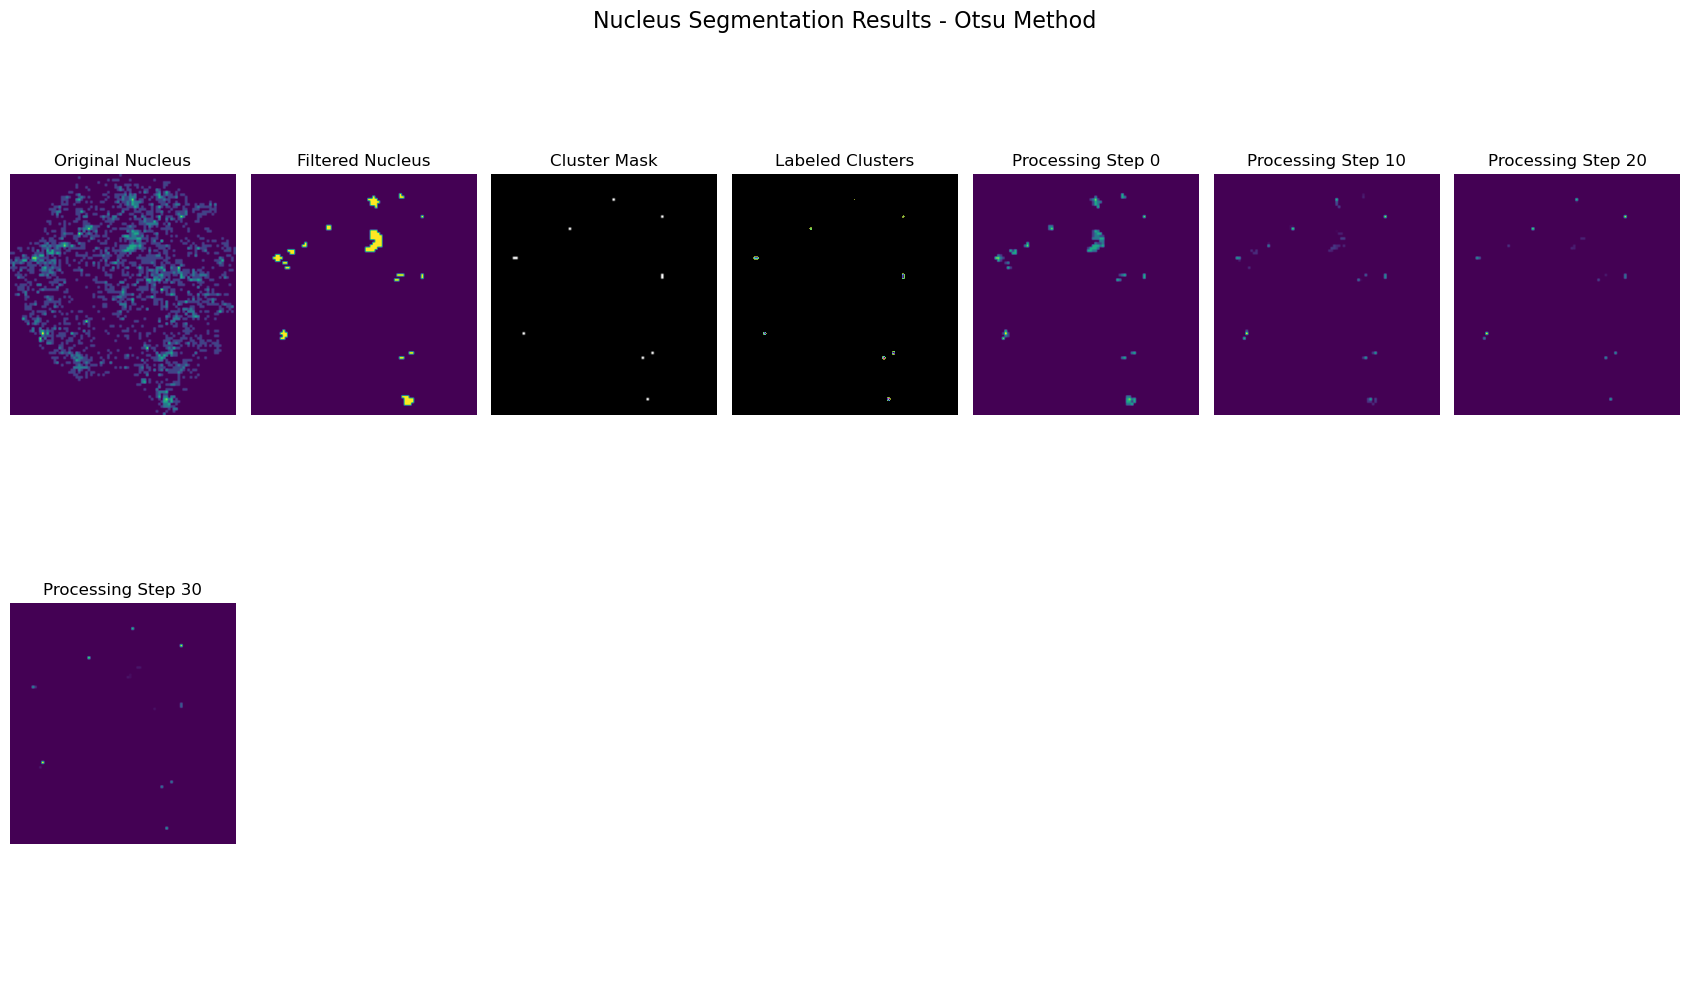

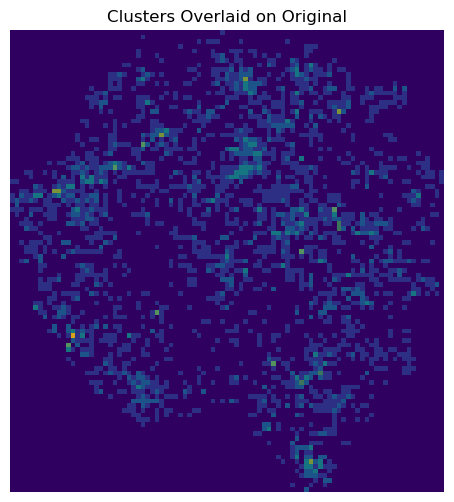

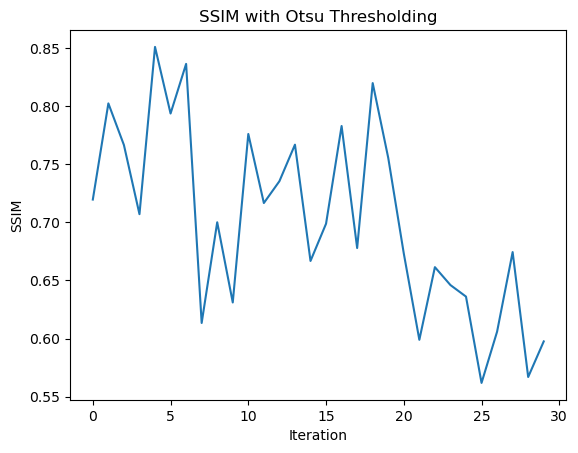

In [85]:
# Plot example of cluster segmentation
%matplotlib inline
# segment_clusters(dataset, nuclear_tracking, nuclear_channel,
#                  frame=4, nucleus_id=27,
#                  sigma_xy=1, z_plane=6
#                  , contour_cutoff=8, plot=True)

cluster_df, processed_slices = segment_clusters(
    dataset=dataset,
    nuclear_tracking=nuclear_tracking,
    nuclear_channel=nuclear_channel,
    frame=2,
    nucleus_id=533,
    method='otsu',
    sigma_xy=1,
    z_plane=2,
    window_size=25,
    iterations=30,
    plot=True,
    filter_type='gaussian',
    plot_intermediate=True
)

# Binarize processed slices and compute structural similarity index SSIM with first entry
binarized_slices = [np.where(slice > 0, 1, 0) for slice in processed_slices]

# Compute SSIM with index 0
from skimage.metrics import structural_similarity as ssim

ssim_results = []
for i, slice_bin in enumerate(binarized_slices[1:], start=1):
    similarity = ssim(binarized_slices[0], slice_bin, data_range=1)
    ssim_results.append(similarity)

# Plot similarity
plt.plot(ssim_results)
plt.title("SSIM with Otsu Thresholding")
plt.xlabel("Iteration")
plt.ylabel("SSIM")
plt.show()

In [86]:
cluster_df = segment_clusters_all_nuclei(dataset, nuclear_tracking, nuclear_channel, method='otsu',
                      sigma_xy=2, plot=False)


2025-04-02 17:50:07,264 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,305 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,340 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,387 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,484 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,510 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,539 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,597 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,624 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,662 - __main__ - WARNING - Cannot apply Otsu method on uniform or NaN slice
2025-04-02 17:50:07,696 - __main__ - WAR

In [87]:
cluster_df.head()

,y_crop,x_crop,y_original,x_original,cluster_id,frame,nucleus_id
0,10.0,16.0,764.0,222.0,1,0,333
1,12.0,18.0,766.0,224.0,2,0,333
2,12.0,57.0,555.0,90.0,1,0,453
3,45.0,35.0,588.0,68.0,2,0,453
4,54.0,31.0,451.0,899.0,1,0,460


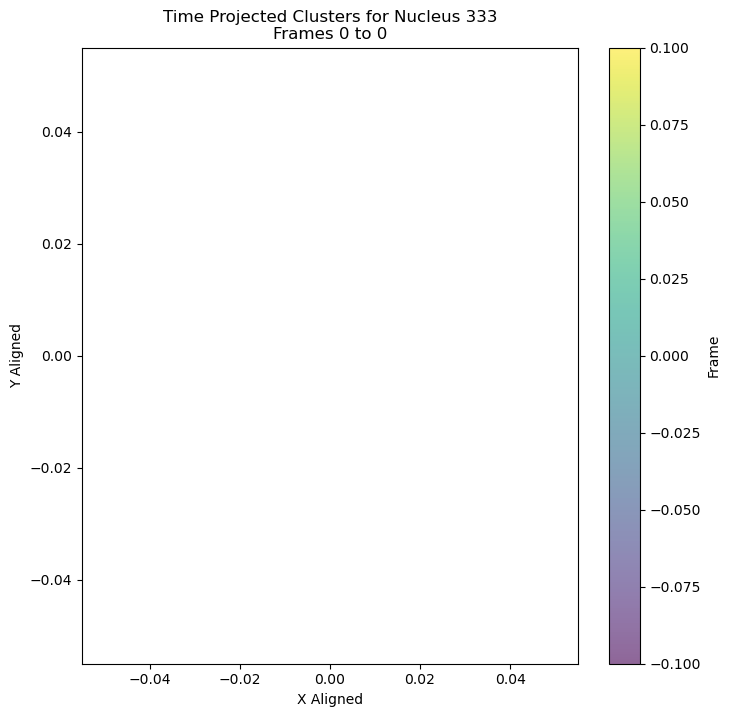

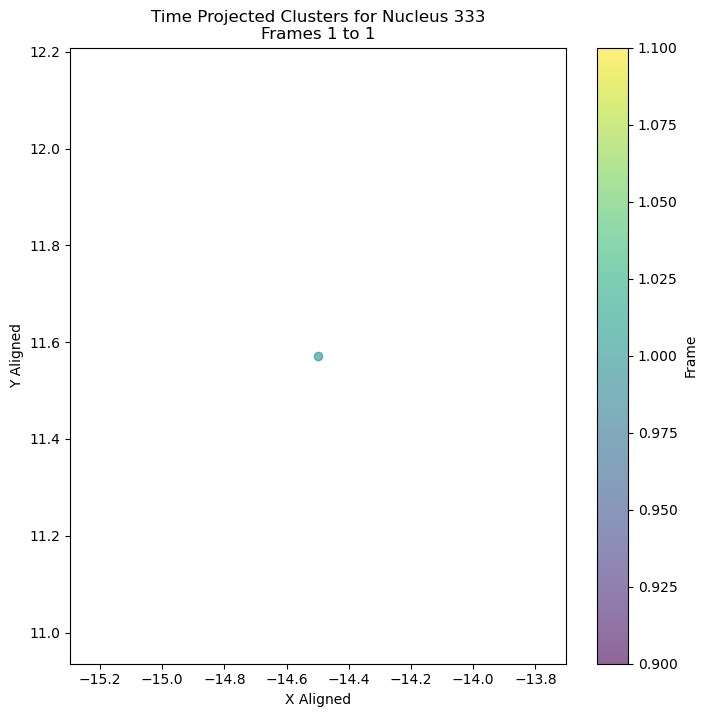

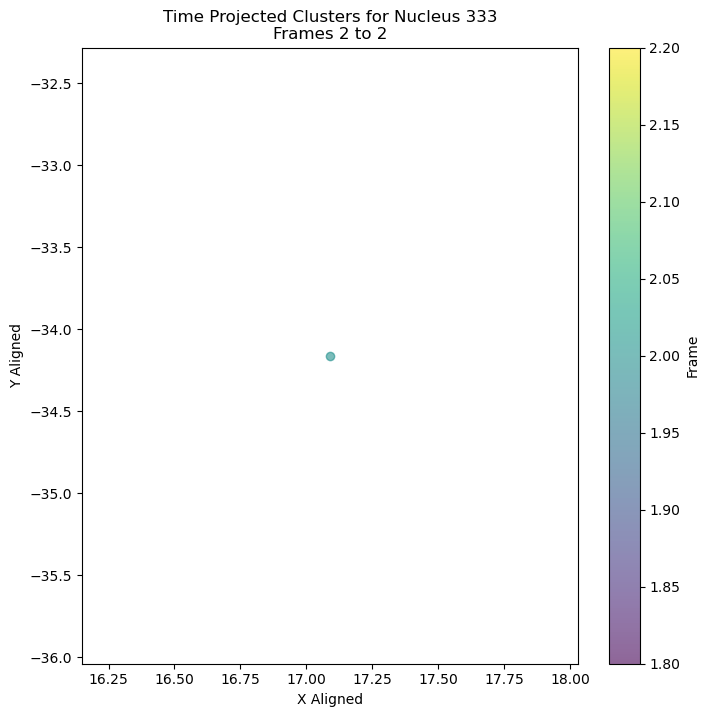

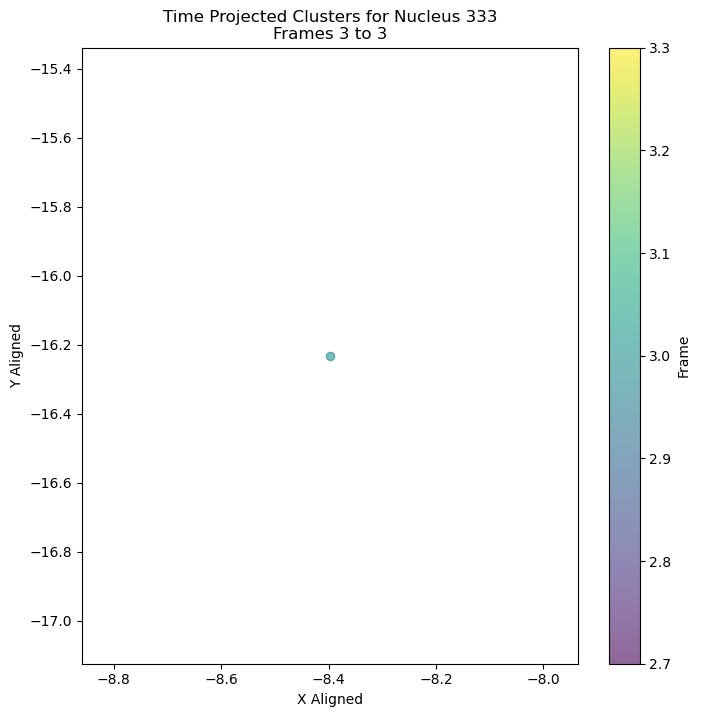

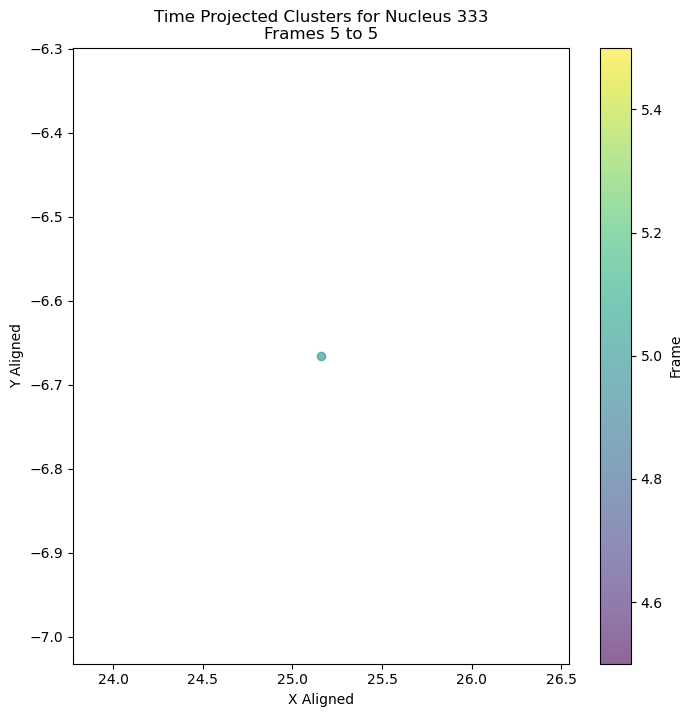

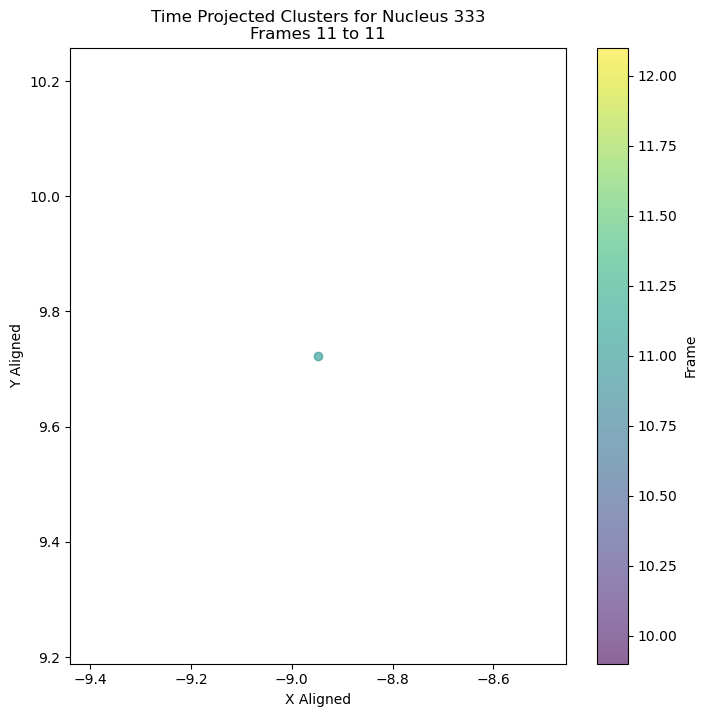

In [90]:
def plot_time_projected_clusters(cluster_df, nuclear_tracking, nucleus_id, frames_stack=60):
    # Filter clusters for the specific nucleus
    nucleus_clusters = cluster_df[cluster_df['nucleus_id'] == nucleus_id]

    # Pull nuclear centroids from nuclear_tracking.mitosis_dataframe
    mitosis_df = nuclear_tracking.mitosis_dataframe
    nucleus_centroids = mitosis_df[mitosis_df['particle'] == nucleus_id][['frame', 'y_pixel', 'x_pixel']]

    # Merge centroid data with cluster data
    merged_df = nucleus_clusters.merge(nucleus_centroids, on='frame', how='left')

    # Align cluster positions using nuclear centroids
    merged_df['y_aligned'] = merged_df['y_original'] - merged_df['y_pixel']
    merged_df['x_aligned'] = merged_df['x_original'] - merged_df['x_pixel']

    # Get unique frames and determine number of plots needed
    unique_frames = sorted(merged_df['frame'].unique())
    num_plots = len(unique_frames) // frames_stack

    for i in range(num_plots):
        start_frame = unique_frames[i * frames_stack]
        end_frame = unique_frames[min((i + 1) * frames_stack, len(unique_frames)) - 1]
        plot_data = merged_df[(merged_df['frame'] >= start_frame) & (merged_df['frame'] <= end_frame)]

        plt.figure(figsize=(8, 8))
        plt.scatter(plot_data['x_aligned'], -plot_data['y_aligned'], c=plot_data['frame'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='Frame')
        plt.xlabel('X Aligned')
        plt.ylabel('Y Aligned')
        plt.title(f'Time Projected Clusters for Nucleus {nucleus_id}\nFrames {start_frame} to {end_frame}')
        plt.show()

plot_time_projected_clusters(cluster_df, nuclear_tracking, nucleus_id=333, frames_stack=1)


In [31]:
def plot_nucleus_time_z(dataset, nuclear_tracking, nuclear_channel, nucleus_id, start_frame, end_frame, start_z, end_z, sigma_xy=1):
    global_min, global_max = np.nanmin(dataset.channels_full_dataset[nuclear_channel]), 0.7*np.nanmax(dataset.channels_full_dataset[nuclear_channel])
    # Create a grid of subplots: time on horizontal axis, z on vertical axis
    fig, axs = plt.subplots(end_z - start_z + 1, end_frame - start_frame + 1, figsize=(15, 10))
    
    for z in range(start_z, end_z + 1):
        for t in range(start_frame, end_frame + 1):
            ax = axs[z - start_z, t - start_frame] if (end_z - start_z + 1 > 1 and end_frame - start_frame + 1 > 1) else axs
            
            cropped_nucleus_slice, _, _, _, min_y, max_y, min_x, max_x = process_nuclear_slice(
                nuclear_tracking.reordered_labels[t, :, :], 
                dataset.channels_full_dataset[nuclear_channel][t, :, :], 
                nucleus_id, sigma_xy, z
            )
            
            if cropped_nucleus_slice is not None:
                ax.imshow(cropped_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
                ax.set_title(f"Time {t}, Z {z}", fontsize=8)  # Subplot title
            
            ax.axis('off')
    
    # Add a main title for the figure
    plt.suptitle(f"Nucleus {nucleus_id}: Time vs Z", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


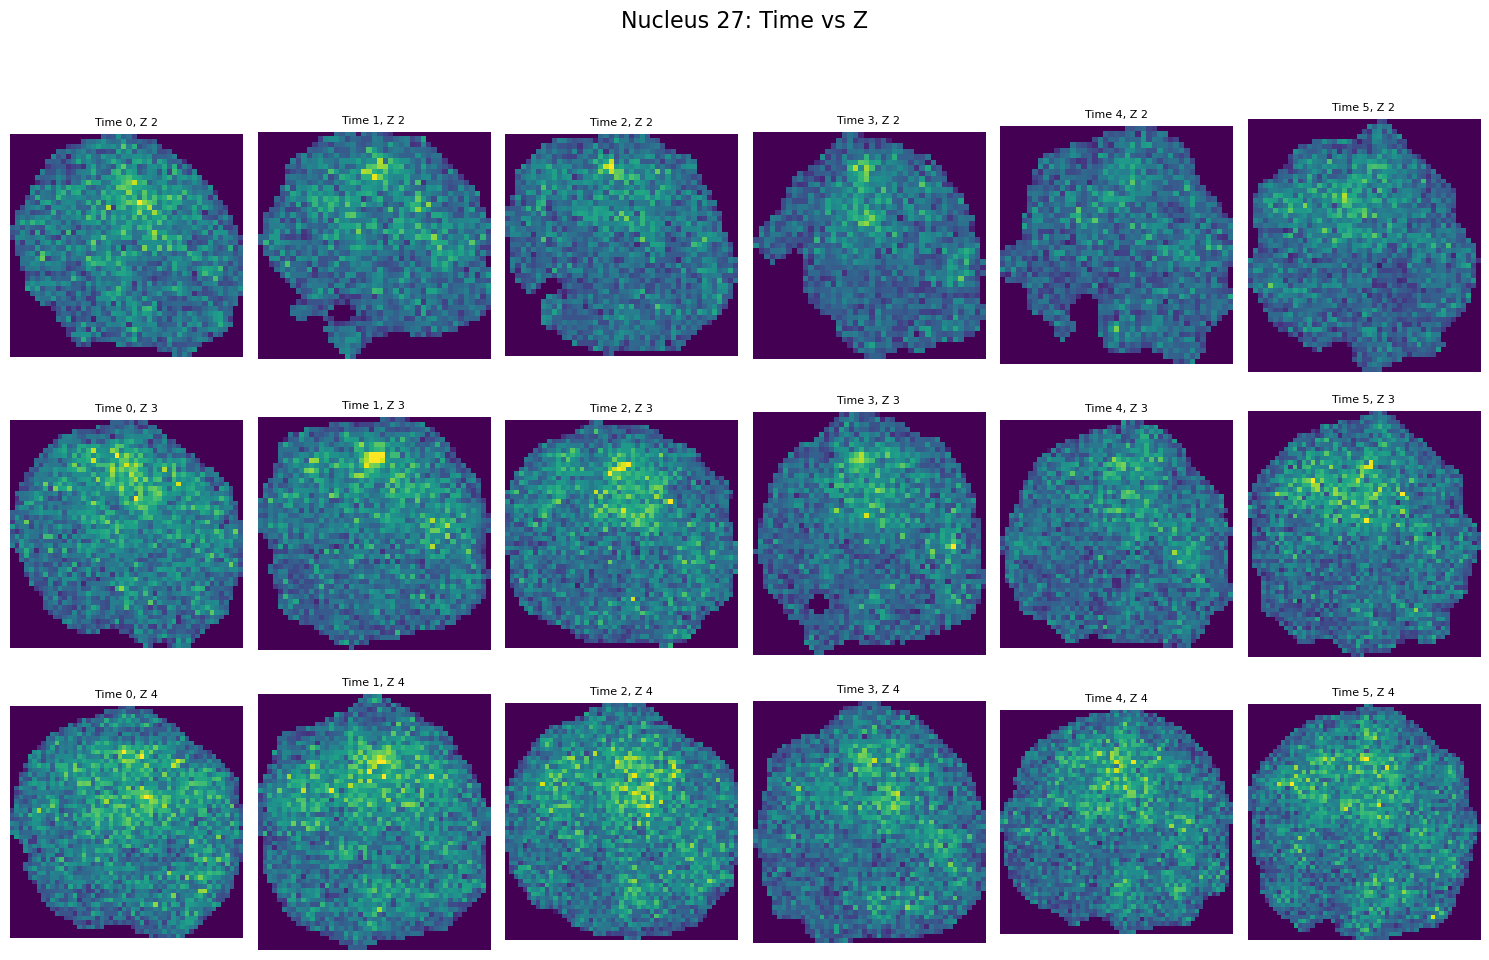

In [32]:
# Plot the raw data for nucleus 27 in time and at different z-planes
plot_nucleus_time_z(dataset, nuclear_tracking, nuclear_channel, nucleus_id=27, sigma_xy=1, start_frame=0, end_frame=5, start_z=2, end_z=4)